# Classification  MODEL

In [45]:
import pandas as pd
import sqlite3

## skip all above

In [46]:
data = pd.read_csv('class_model.csv')

In [47]:
data.head()

,faculty_code,faculty,course_code,course_name,class,teacher,year,day,start_time,end_time,student_nums
0,GÖRSEL İLETİŞİM TASARIMI_GSF102,GÖRSEL İLETİŞİM TASARIMI,GSF102,TEMEL TASARIM II,L-102(GİT ATÖLYE II)[60],SEÇİL KARTOPU,1,Pazartesi,09:00,14:50,41
1,GÖRSEL İLETİŞİM TASARIMI_GSF106,GÖRSEL İLETİŞİM TASARIMI,GSF106,ÇİZİM II,L-101(GİT ATÖLYE I)[60],Öğr.Gör. İSMAİL FURKAN YAVUZ,1,Pazartesi,09:00,14:50,44
2,GÖRSEL İLETİŞİM TASARIMI_BLG102,GÖRSEL İLETİŞİM TASARIMI,BLG102,BİLGİ TEKNOLOJİLERİ KULLANIMI,AZ 13(BİLGİSAYAR LAB.)[80],Öğr.Gör. AHMET AKSOY,1,Salı,09:00,15:20,44
3,İKTİSAT_ENG104,İKTİSAT,ENG104,ACADEMIC ENGLISH II,B382(KONFERANS SALONU)[143],Öğr.Gör. MÜGE AKGEDİK AKOĞLANOĞLU,1,Pazartesi,09:00,16:20,35
4,İKTİSAT_ECON102,İKTİSAT,ECON102,INTRODUCTION TO ECONOMICS II,B338-D1(DERSLİK1)[121],KORAY GÖKSAL,1,Pazartesi,14:00,16:20,91


In [48]:
print(f'there are {len(data.columns)} columns and {len(data)} rows')

there are 11 columns and 572 rows


### STEP 1: structure the data for the model

In [49]:
# list all the columns to drop

print(data.columns)

Index(['faculty_code', 'faculty', 'course_code', 'course_name', 'class',
       'teacher', 'year', 'day', 'start_time', 'end_time', 'student_nums'],
      dtype='object')


In [50]:
to_drop = ['faculty_code', 'faculty', 'course_name', 'class', 'year', 'start_time']

In [51]:
data.drop(labels=to_drop,axis=1, inplace=True)

In [52]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [53]:
import pandas as pd
from datetime import datetime, timedelta

def calculate_bus_stop_counts(df):
    """
    Takes a class schedule DataFrame and returns a new DataFrame with time slots and bus_stop_count.
    Works using minutes-from-midnight as time representation.
    
    Required columns in df:
    - 'day' (e.g., Monday)
    - 'end_time' (string in 'HH:MM' format)
    - 'student_nums' (integer)
    """
    
    # Convert end_time to datetime for parsing, then extract minutes-from-midnight
    df['end_time'] = pd.to_datetime(df['end_time'], format='%H:%M')
    df['end_time_minutes'] = df['end_time'].dt.hour * 60 + df['end_time'].dt.minute
    
    time_slots = []

    for _, row in df.iterrows():
        end_time_min = row['end_time_minutes']
        student_count = row['student_nums']
        day = row['day']
        
        # Define departure distribution
        departures = [
            (0, 0.20),  # 0-5 minutes
            (5, 0.50),  # 5-10 minutes
            (10, 0.30)  # 10-15 minutes
        ]

        for offset, fraction in departures:
            slot_min = end_time_min + offset  # Still in minutes-from-midnight
            time_slots.append({
                'day': day,
                'time_slot_minutes': slot_min,
                'bus_stop_count': int(student_count * fraction)
            })

    # Create DataFrame from list of time slots
    result_df = pd.DataFrame(time_slots)

    # Group by day and time slot to sum overlapping students
    result_df = result_df.groupby(['day', 'time_slot_minutes'], as_index=False).sum()
    #result_df['time_slot'] = result_df['time_slot_minutes'].apply(lambda x: f"{x // 60:02}:{x % 60:02}")


    return result_df


In [54]:
data = calculate_bus_stop_counts(data)
print(data)

          day  time_slot_minutes  bus_stop_count
0        Cuma                650              30
1        Cuma                655              78
2        Cuma                660              46
3        Cuma                710              91
4        Cuma                715             232
..        ...                ...             ...
145  Çarşamba                985             488
146  Çarşamba                990             288
147  Çarşamba               1070              25
148  Çarşamba               1075              63
149  Çarşamba               1080              37

[150 rows x 3 columns]


In [55]:
def density_estimation(df):

    # low -> 40 AND BELOW
    # MEDIUM -> 41 - 80
    # HIGH -> 81+

    density = ['LOW', 'MEDIUM', 'HIGH']
    student_density = []

    for _, row in df.iterrows():

        if row['bus_stop_count'] <= 60:
            student_density.append(density[0]) 
        elif row['bus_stop_count'] > 60 and row['bus_stop_count'] <= 100:
            student_density.append(density[1]) 
        elif row['bus_stop_count'] > 100:
            student_density.append(density[2])

    df['density'] = student_density 
    return df

In [56]:
data = density_estimation(data)

In [57]:
data

,day,time_slot_minutes,bus_stop_count,density
0,Cuma,650,30,LOW
1,Cuma,655,78,MEDIUM
2,Cuma,660,46,LOW
3,Cuma,710,91,MEDIUM
4,Cuma,715,232,HIGH
...,...,...,...,...
145,Çarşamba,985,488,HIGH
146,Çarşamba,990,288,HIGH
147,Çarşamba,1070,25,LOW
148,Çarşamba,1075,63,MEDIUM


next encoding

In [58]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [59]:
density_col = data['density']

In [60]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [61]:
print(density_col)

0         LOW
1      MEDIUM
2         LOW
3      MEDIUM
4        HIGH
        ...  
145      HIGH
146      HIGH
147       LOW
148    MEDIUM
149       LOW
Name: density, Length: 150, dtype: object


In [62]:
le = LabelEncoder()

In [63]:
d_ = le.fit_transform(density_col)

In [64]:
data['density'] = d_

In [65]:
data

,day,time_slot_minutes,bus_stop_count,density
0,Cuma,650,30,1
1,Cuma,655,78,2
2,Cuma,660,46,1
3,Cuma,710,91,2
4,Cuma,715,232,0
...,...,...,...,...
145,Çarşamba,985,488,0
146,Çarşamba,990,288,0
147,Çarşamba,1070,25,1
148,Çarşamba,1075,63,2


In [66]:
oh = OneHotEncoder()

# one hot encoding for the days column
## we commented it out because the randomforestclassifier does not need one hot encoding

In [67]:
"""
days = pd.get_dummies(data['day'], prefix='day')
new_drop = ['day']
data.drop(labels=new_drop, axis=1, inplace=True)
_d = days.apply(le.fit_transform)
data = data.join(_d)
"""

"\ndays = pd.get_dummies(data['day'], prefix='day')\nnew_drop = ['day']\ndata.drop(labels=new_drop, axis=1, inplace=True)\n_d = days.apply(le.fit_transform)\ndata = data.join(_d)\n"

In [68]:
data

,day,time_slot_minutes,bus_stop_count,density
0,Cuma,650,30,1
1,Cuma,655,78,2
2,Cuma,660,46,1
3,Cuma,710,91,2
4,Cuma,715,232,0
...,...,...,...,...
145,Çarşamba,985,488,0
146,Çarşamba,990,288,0
147,Çarşamba,1070,25,1
148,Çarşamba,1075,63,2


In [69]:
data['day_encoded'] = le.fit_transform(data['day'])

In [70]:
data = data.drop(columns=['day'])


In [71]:
data

,time_slot_minutes,bus_stop_count,density,day_encoded
0,650,30,1,0
1,655,78,2,0
2,660,46,1,0
3,710,91,2,0
4,715,232,0,0
...,...,...,...,...
145,985,488,0,4
146,990,288,0,4
147,1070,25,1,4
148,1075,63,2,4


In [72]:
data.to_csv('classification_model_data.csv', index=False)

## model

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
X = data.drop(labels=['density'], axis=1)
y = data['density']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
model = RandomForestClassifier(class_weight={0: 1, 1: 2, 2: 4})
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 2, 2: 4})

In [78]:
from sklearn.metrics import classification_report

In [79]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.90      1.00      0.95         9
           2       1.00      0.86      0.92         7

    accuracy                           0.97        30
   macro avg       0.97      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30



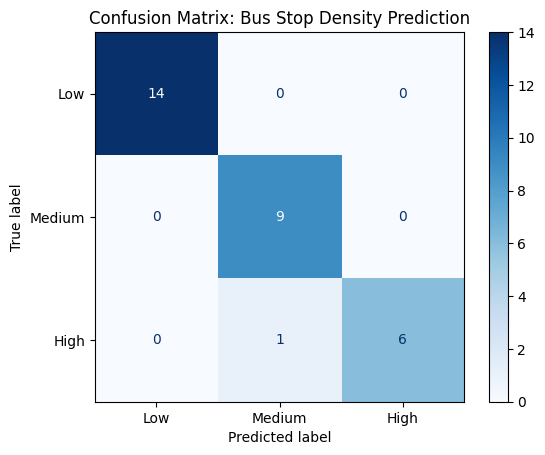

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test is your true labels, and y_pred is your model's predictions
cm = confusion_matrix(y_test, y_pred)

# Optional: label the classes (adjust based on your label encoding)
labels = ['Low', 'Medium', 'High']

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix: Bus Stop Density Prediction")
plt.show()


These results look **excellent**, especially for a classification problem with three classes! Let’s break it down and interpret what this means for your project. 👇

---

### 📊 **Overview of Results**
| Metric        | Explanation                                    | Value  |
|---------------|------------------------------------------------|--------|
| **Accuracy**  | Overall correctness of the model               | 97% ✅ |
| **Precision** | When it says "Class X", how often it's right   | High across all |
| **Recall**    | How well it finds all examples of Class X      | High for all, slightly lower for Class 2 |
| **F1-score**  | Balance between precision & recall             | All above 0.92 — excellent |

---

### 🔍 **Per-Class Insights**

- **Class 0 (Low Density)**  
  - Perfect precision and recall (1.00) ➝ Model is confident and correct when predicting this class.
  
- **Class 1 (Medium Density)**  
  - Precision: 0.88 ➝ A few false positives (it predicted Medium but the truth was another class)
  - Recall: 1.00 ➝ It found *all* Medium density instances

- **Class 2 (High Density)**  
  - Precision: 1.00 ➝ Every time it predicted High, it was right  
  - Recall: 0.86 ➝ It *missed* one of the High density instances and predicted it as something else


In [81]:
import pandas as pd

# Create a DataFrame to display feature importances
importances = model.feature_importances_
feature_names = X_train.columns
feat_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importances_df = feat_importances_df.sort_values(by='Importance', ascending=False)
print(feat_importances_df)


             Feature  Importance
1     bus_stop_count    0.774245
0  time_slot_minutes    0.174568
2        day_encoded    0.051188


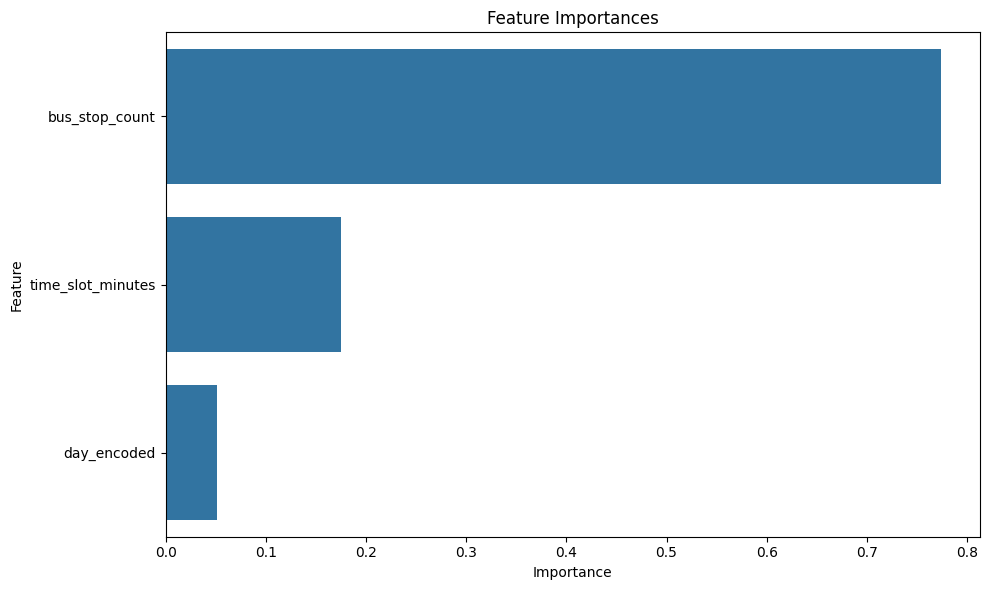

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


In [83]:
time = data.loc[(data['time_slot_minutes'] == 960)]
print(time)

Empty DataFrame
Columns: [time_slot_minutes, bus_stop_count, density, day_encoded]
Index: []


In [84]:
filtered = data[data['time_slot_minutes'] == 930]
print(filtered)


     time_slot_minutes  bus_stop_count  density  day_encoded
14                 930             180        0            0
44                 930             472        0            1
77                 930             424        0            2
112                930             698        0            3
143                930             520        0            4


In [85]:
from xgboost import XGBClassifier

In [86]:
xgbmodel = XGBClassifier()

In [87]:
xgbmodel.fit(X_train, y_train)
y_predict = xgbmodel.predict(X_test)

In [88]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.90      1.00      0.95         9
           2       1.00      0.86      0.92         7

    accuracy                           0.97        30
   macro avg       0.97      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30

